# Deep Learning - Handcrafted Models
### *Facial age prediction - a SML Regression problem*

# 1. References

1. LeNet with Tensorflow, [blog article](https://medium.com/analytics-vidhya/lenet-with-tensorflow-a35da0d503df)
2. Wikipedia: LeNet, [link](https://en.wikipedia.org/wiki/LeNet)
3. Deep Learning with Python, 2017, Francois Chollet, page. 129
4. How to choose the right activation function for neural networks, [blog article](https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c)
5. What are the advantages of relu over sigmoid function in deep neural networks?, [blog article](https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks?sfb=2)
6. ReLu vs Sigmoid Function in Deep Neural Networks, [blog article](https://wandb.ai/ayush-thakur/dl-question-bank/reports/ReLU-vs-Sigmoid-Function-in-Deep-Neural-Networks--VmlldzoyMDk0MzI)
8. Where droput should be inserted, [blog article](https://stackoverflow.com/questions/46841362/where-dropout-should-be-inserted-fully-connected-layer-convolutional-layer)
9. Dropout layers in a neural network, [blog article](https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network)
10. Improving neural networks by preventing co-adaptation of feature detectors, G. E. Hinton et. al, 2012
11. Regularization in deep learning, [blog article](https://towardsdatascience.com/regularization-in-deep-learning-l1-l2-and-dropout-377e75acc036)
12. When to apply L1 or L2 regularization to neural network weights, [blog article](https://analyticsindiamag.com/when-to-apply-l1-or-l2-regularization-to-neural-network-weights/)
13. Guidelines for selecting an optimizer for training neural networks,  [blog article](https://datascience.stackexchange.com/questions/10523/guidelines-for-selecting-an-optimizer-for-training-neural-networks)
14. ImageNet Classification with Deep Convolutional
Neural Networks, Alex Krizhevsky et. al, 2012
15. Introduction to the architecture of AlexNet, [blog article](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/)
16. Batch Normalization: Accelerating Deep Network Training by
Reducing Internal Covariate Shift, Sergey Ioffe and Christian Szegedy, 2015


# 2. Initial Treatment

## 2.1. Configurations and import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics, losses, utils, datasets 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from sklearn.utils.class_weight import compute_class_weight

import datetime
import os
import time
import shutil
import random 
import zipfile
from PIL import Image
from collections import Counter
from pathlib import Path
import pickle


## 2.2. Auxiliary functions

Collection of all user defined functions in this notebook. 

In [ ]:
def set_global_seed(seed):
    """
    Set global random seed for reproducibility across various libraries.

    Parameters:
    ----------
    seed : int
        The random seed to be set.

    Returns:
    -------
    None.
    """
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
def plot_loss(model, ylim, model_name=None):
    """
    Plots the training and validation loss curves for a single model.

    Args:
    --
    - model (keras.callbacks.History): Trained model object.
    - y_axis_range (tuple): Tuple containing the minimum and maximum y-axis values for the plot.
    - model_name (str): Optional name of the model to be included in the plot title.

    Returns:
    --
    - None

    """
# Create DataFrame object
    df_hist = pd.DataFrame.from_dict(model.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
    # Plot learning curves
    ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="MSE", 
                    xlabel="Epoch", title=f"Learning curves {model_name}",                  
                    color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
    # ax.right_ax.set_ylabel("MSE")
    # ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
    ax.legend(loc=(0, -0.45), framealpha=1.0)
    ax.set_ylim(ylim)
    plt.xticks(np.arange(1, len(df_hist)+1, 1.0))


In [ ]:
def plot_all_models(dict):
    """
    Plots the training and validation loss curves for multiple models in separate subplots.

    Args:
    --
    - dict (dict): Dictionary containing trained models and their training history.

    Returns:
    --
    - None
    """
    fig, axs = plt.subplots(int(np.ceil(len(dict)/2)), 2, figsize=(20, 10))
    axs = axs.ravel() if len(dict) > 1 else [axs]

    for ax_index, model in enumerate(dict.keys()):
        df_hist = pd.DataFrame.from_dict(dict[model].history)
        df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
        # Plot learning curves
        df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                        kind="line", figsize=(8, 12), grid=True, legend=True,
                        ylabel="MSE", 
                        xlabel="Epoch",                  
                        color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=6,
                        ax=axs[ax_index])
        axs[ax_index].set_ylim([0, 800])
        axs[ax_index].set_title(f"Learning curves {model}", fontsize=11) 
        axs[ax_index].set_xticks(np.arange(1, len(df_hist)+1, 1.0, dtype=int))  
        axs[ax_index].set_yticks(np.arange(0, 800, 100))  
        axs[ax_index].xaxis.label.set_size(8)  
        axs[ax_index].yaxis.label.set_size(8)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
def plot_compare_models(model_names, model_dict, ylim):
    """
    Plots the training and validation loss curves for multiple models in the same plot for comparison.

    Args:
    --
    - model_names (list): List of model names to be plotted.
    - model_dict (dict): Dictionary containing trained models and their training history.

    Returns:
    --
    - None

    """
    fig, ax = plt.subplots(figsize=(6, 3))
    colors = matplotlib.colormaps['Paired']
    color_index = 0
    for name in model_names:
        df_hist = pd.DataFrame.from_dict(model_dict[name].history)
        df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
        ax.plot(df_hist["Epoch"], df_hist['loss'], label=f'{name} loss', color=colors(color_index))
        color_index += 1
        ax.plot(df_hist["Epoch"], df_hist['val_loss'], label=f'{name} val_loss', color=colors(color_index))
        color_index += 1
    ax.legend(loc="best", framealpha=1.0, fontsize=6.5)
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.set_title(f"Compare models")
    ax.grid(True)
    ax.set_ylim(ylim)
    # plt.yticks(np.arange(0, 800, 100))
    plt.xticks(np.arange(1, len(df_hist)+1, 1.0, dtype=int))
    plt.show()


In [ ]:
def train_model(model, train_df, validation_df, epochs, batch_size, optimizer):
  ''' 
  Compiles and trains the model on the train and validation datasets.
  Additionally the training time is tracked.
  
  Args:
  --
  - model (keras.Model): A Keras model instance to be trained.
  - train_df (pandas.DataFrame): A DataFrame containing the training data.
  - validation_df (pandas.DataFrame): A DataFrame containing the validation data.
  - epochs (int): An integer representing the number of times to iterate over the entire training dataset.
  - batch_size (int): An integer representing the number of samples per gradient update.
  - optimizer (str or keras.optimizers.Optimizer): A string or an instance of a Keras optimizer to use for training.

  Returns:
  --
  - history (keras.callbacks.History): A History object containing the training loss and metric values at successive epochs, 
  as well as validation loss and metric values (if applicable).
  '''
  tf.keras.backend.clear_session()
  model.compile(optimizer=optimizer,
                loss = losses.MeanSquaredError(),
                metrics=[metrics.MeanAbsolutePercentageError(name='MAPE')]
                )

  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  print(f"Start training of {model.__class__.__name__}: {model.__doc__}")
  start = time.time()
  history = model.fit(train_df, validation_data=validation_df,
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[early_stopping])
  print("Training time: {:.4f}s".format(time.time() - start), end="\n\n")

  return history

## 2.3. Import dataset

In the following all paths for the data import will be defined.

In [ ]:
# Define the path, where the dataset should be saved
vm_path = "/content"
path = "/content/drive/MyDrive/FacialAgeProject/"

data_path = os.path.join(path, 'data')
metadata_path = os.path.join(path, 'metadata')
dataset_path = os.path.join(data_path, "facial_age_dataset_unsplit/")

preprocessed_path = os.path.join(data_path, 'facial_age_dataset_preprocessed')

train_path = Path(os.path.join(preprocessed_path, 'train'))
test_path = Path(os.path.join(preprocessed_path, 'test'))

# metadata_csv_path = os.path.join(metadata_path, 'images_metadata.csv')
metadata_csv_path = path + 'metadata/images_metadata.csv'

In [ ]:
# Image dataset with all the files configurations.
images_df = pd.read_csv(metadata_csv_path)
images_df = images_df.sample(frac = 1.0).reset_index(drop = True)
images_df.head()

# Train dataset to be used in the generator.
train_file_names = pd.Series(list(train_path.glob(r'**/*.png')),name = 'file_names').astype('str')
train_file_names = train_file_names.apply(lambda x : x.split('/')[-1])
train_images_df = images_df[images_df['file_name'].isin(train_file_names)]
train_images_df['file_name'] = '..' + f'{train_path}'+ '/' + train_images_df['age_label'].apply(lambda x : f"{x:03d}") + '/' + train_images_df['file_name']

# Test dataset to be used in the generator.
test_file_names = pd.Series(list(test_path.glob(r'**/*.png')),name = 'file_names').astype('str')
test_file_names = test_file_names.apply(lambda x : x.split('/')[-1])
test_images_df = images_df[images_df['file_name'].isin(test_file_names)]
test_images_df['file_name'] = '..' + f'{test_path}'+ '/' + test_images_df['age_label'].apply(lambda x : f"{x:03d}") + '/' + test_images_df['file_name']

print('Train files and dataset lenght (must check) : {} vs {}'.format(len(train_file_names),train_images_df.shape[0]))
print('test files and dataset lenght (must check) : {} vs {}'.format(len(test_file_names),test_images_df.shape[0]))

In [ ]:
# Initialize global variables.
batch_size = 64
seed = 0
set_global_seed(0)

In [ ]:
# Data generators and parameters
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

generate_params = {
    'target_size' : (200,200),
    'color_mode' : 'rgb',
    'class_mode' : 'raw',
    'batch_size' : batch_size,
    'seed' : seed
}

In [ ]:
# Generators instances and data spliting
ds_train = train_generator.flow_from_dataframe(
    dataframe=train_images_df,
    x_col='file_name',
    y_col='age_label',
    #weight_col = 'weights',
    shuffle=True,
    subset='training',
    **generate_params
)

ds_val = train_generator.flow_from_dataframe(
    dataframe=train_images_df,
    x_col='file_name',
    y_col='age_label',
    shuffle=True,
    subset='validation',
    **generate_params
)

ds_test = test_generator.flow_from_dataframe(
    dataframe=test_images_df,
    x_col='file_name',
    y_col='age_label',
    **generate_params
)

Found 5607 validated image filenames.
Found 1401 validated image filenames.
Found 1752 validated image filenames.


# 3. First architecture - the LeNet

The LeNet architecture was chosen at first as it represents the starting point for convolutional neural networks. It is comparatively simpler in design than other architectures like VGG and ResNet, consisting of only seven layers, which reduces its computational complexity [1][2]. 
Originally developed to predict simple images with limited variations in appearance, we chose to experiment with it to gain better insights into how the dataset behaves in the models. Furthermore, the LeNet architecture enables us to easily add various parameters such as optimizers and conduct more testing without substantial time loss. The metrics we will employ to evaluate the model's performance across all our notebooks are Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE).

## 3.1 LeNet-V1 Basic Architecture

The current model utilizes the original architecture developed by Y. LeCun in 1998 [1][2]. We made adjustments to the LeNet architecture according to our requirements. These adjustments involved adding a Rescaling layer that rescales pixel values from the original range of (0, 255) to (0, 1), in order to normalize the input data and potentially improve the model's training performance. Additionally, we modified the original Dense layer with 10 units and Softmax activation, which was used for multi-classification problems, to a Dense layer with a single unit and Linear activation, as we are now dealing with a regression problem rather than a multi-class classification problem.

In [ ]:
# Defines a dictionary for saving the trained models 
# to compare them later.
model_dict = {}
# Initializing different model parameters.
input_shape = (None, 200, 200, 3)
epochs= 10
learning_rate = 0.001

In [ ]:
class LeNet_v1(tf.keras.Model):
    '''LeNet-V1 Basic Architecture'''
    def __init__(self, seed=0,
                conv_1_filters = 6, 
                conv_2_filters = 16,
                kernel = (5,5),
                 ):
        super().__init__()
        self.resize = layers.Rescaling(1./255)
        # Convolutional layers (with learnable parameters)
        self.conv_1 = layers.Conv2D(filters=conv_1_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="same")
        self.conv_2 = layers.Conv2D(filters=conv_2_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="valid")
        # Fully conected layers
        self.dense_1 = layers.Dense(units=120, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense_2 = layers.Dense(units=84, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers (define only once)
        self.sigmoid = layers.Activation("sigmoid")
        self.averagepooling = layers.AveragePooling2D(pool_size=2, strides=2)
        self.flatten = layers.Flatten()
        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.resize(inputs)
        x = self.conv_1(x)
        x = self.sigmoid(x)
        x = self.averagepooling(x)
        x = self.conv_2(x)
        x = self.sigmoid(x)
        x = self.averagepooling(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.output_layer(x)

        return x

#### 3.1.1. Building the model

In [ ]:
# Build and plot the summary of the model and 
# architecture.
lenet_v1 = LeNet_v1()
lenet_v1.build(input_shape)
lenet_v1.summary()

Model: "le_net_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  456       
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 dense (Dense)               multiple                  4423800   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

#### 3.1.2. Compiling and training

In [ ]:
# Compiles and trains the model.
# As optimizer we use the default optimizer RMSprop.
history_lenet_v1 = train_model(model=lenet_v1, 
                                train_df=ds_train, 
                                validation_df=ds_val, 
                                epochs=epochs, 
                                batch_size=batch_size, 
                                optimizer=optimizers.RMSprop(learning_rate=learning_rate))

model_dict[f"{history_lenet_v1.model.__class__.__doc__}"] = history_lenet_v1

Start training of LeNet_v1: LeNet-V1 Basic Architecture
Epoch 1/10
88/88 [==============================] - 55s 529ms/step - loss: 873.0982 - MAPE: 137.1606 - val_loss: 727.7559 - val_MAPE: 178.1345
Epoch 2/10
88/88 [==============================] - 13s 143ms/step - loss: 675.4989 - MAPE: 218.3101 - val_loss: 578.8885 - val_MAPE: 259.9315
Epoch 3/10
88/88 [==============================] - 12s 137ms/step - loss: 549.6080 - MAPE: 306.5539 - val_loss: 485.2311 - val_MAPE: 350.7932
Epoch 4/10
88/88 [==============================] - 12s 133ms/step - loss: 483.6453 - MAPE: 392.5296 - val_loss: 454.7739 - val_MAPE: 427.0125
Epoch 5/10
88/88 [==============================] - 13s 151ms/step - loss: 468.7895 - MAPE: 443.3749 - val_loss: 453.6391 - val_MAPE: 455.3172
Epoch 6/10
88/88 [==============================] - 13s 147ms/step - loss: 468.2896 - MAPE: 455.9901 - val_loss: 453.5299 - val_MAPE: 452.8617
Epoch 7/10
88/88 [==============================] - 12s 135ms/step - loss: 468.2894 - 

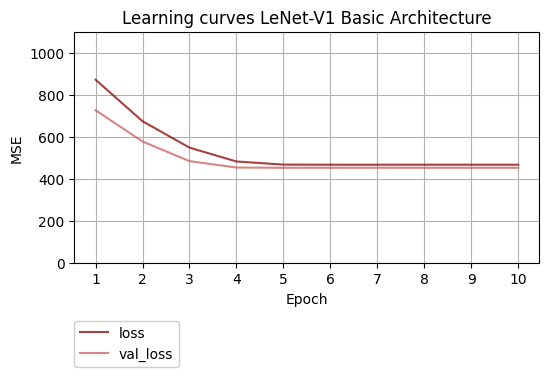

In [ ]:
plot_loss(history_lenet_v1, 
          model_name= f"{history_lenet_v1.model.__class__.__doc__}",
          ylim=[0, 1100])

#### 3.1.3. Observations

The initial architecture indicates that the model stops learning and converges to a suboptimal solution after the fourth epoch. As the original LeNet was designed to classify simple images with limited variations, it may not be suitable for our facial age prediction problem. 
Hence, we need to explore our own architecture in the next step. One of our ideas is to replace the AveragePooling layers with MaxPooling layers, as the latter captures the most prominent feature present in the input feature map and avoids missing or diluting feature-presence information.[3] This is particularly crucial for age prediction of human faces, where minor details like wrinkles play a significant role. Additionally, we have replaced the Sigmoid activation function in the convolutional and fully connected layers with the more computationally efficient ReLU function, which shows better convergence performance than Sigmoid in practical applications. [4][5][6]

## 3.2. LeNet-V2 MaxPooling layers + ReLu activation
In this architecture we will switch from the Sigmoid to ReLu activation and from Average Pooling to Max Pooling.


In [ ]:
class LeNet_v2(tf.keras.Model):
    '''LeNet-V2 MaxPooling layers + ReLu activation'''
    def __init__(self, seed=0,
                conv_1_filters = 6, 
                conv_2_filters = 16,
                kernel = (5,5),
                 ):
        super().__init__()
        self.resize = layers.Rescaling(1./255)
        # Convolutional layers (with learnable parameters)
        self.conv_1 = layers.Conv2D(filters=conv_1_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="same")
        self.conv_2 = layers.Conv2D(filters=conv_2_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="valid")
        # Fully conected layers
        self.dense_1 = layers.Dense(units=120, activation="relu", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense_2 = layers.Dense(units=84, activation="relu", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.flatten = layers.Flatten()
        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.resize(inputs)
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.output_layer(x)

        return x

### 3.2.1. Building the model

In [ ]:
# Build and plot the summary of the model and 
# architecture.
lenet_v2 = LeNet_v2()
lenet_v2.build(input_shape)
lenet_v2.summary()

Model: "le_net_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  456       
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 dense (Dense)               multiple                  4423800   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

### 3.2.2. Compiling and training

In [ ]:
# Compiles and trains the model.
# As optimizer we use the default optimizer RMSprop.
history_lenet_v2 = train_model(model=lenet_v2, 
                                train_df=ds_train, 
                                validation_df=ds_val, 
                                epochs=epochs, 
                                batch_size=batch_size, 
                                optimizer=optimizers.RMSprop(learning_rate=learning_rate))

model_dict[f"{history_lenet_v2.model.__class__.__doc__}"] = history_lenet_v2

Start training of LeNet_v2: LeNet-V2 MaxPooling layers + ReLu activation
Epoch 1/10
88/88 [==============================] - 13s 137ms/step - loss: 547.1423 - MAPE: 397.6305 - val_loss: 382.3914 - val_MAPE: 160.4850
Epoch 2/10
88/88 [==============================] - 12s 134ms/step - loss: 354.5842 - MAPE: 213.0327 - val_loss: 274.2726 - val_MAPE: 221.8356
Epoch 3/10
88/88 [==============================] - 12s 133ms/step - loss: 282.5889 - MAPE: 144.6903 - val_loss: 196.0611 - val_MAPE: 113.7835
Epoch 4/10
88/88 [==============================] - 11s 129ms/step - loss: 244.9164 - MAPE: 118.1462 - val_loss: 291.9709 - val_MAPE: 56.5343
Epoch 5/10
88/88 [==============================] - 12s 133ms/step - loss: 212.2979 - MAPE: 97.7517 - val_loss: 180.7359 - val_MAPE: 126.8891
Epoch 6/10
88/88 [==============================] - 12s 132ms/step - loss: 188.9806 - MAPE: 92.0706 - val_loss: 152.6179 - val_MAPE: 112.2882
Epoch 7/10
88/88 [==============================] - 11s 129ms/step - los

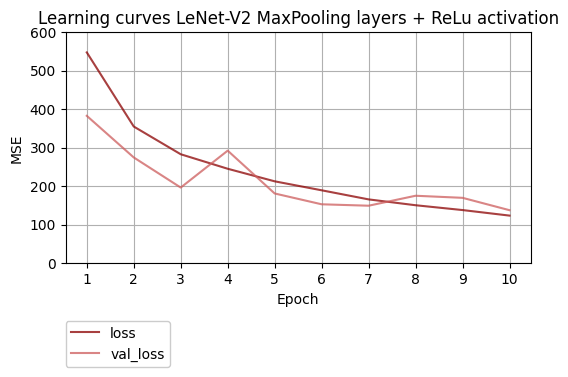

In [ ]:
plot_loss(history_lenet_v2, 
          model_name= f"{history_lenet_v2.model.__class__.__doc__}",
          ylim=[0, 600])

### 3.2.3. Observations

Throughout the training process, V2 model shows consistent convergence across epochs and a corresponding decrease in its loss function. Compared to V1, V2 model performs significantly better based on the MSE metric and continues to learn with each epoch. Nevertheless, the validation results show a non-smooth movement of the learning curve, with an increase in MSE during certain epochs, which shows, that the model is struggling to generalize on unseen data. In the next architecture, we will incorporate techniques to overcome this issue of overfitting.

## 3.3. LeNet-V3 Data Augmentation (Simple)

The primary objective of this architecture is to address the issue of overfitting observed in the previous model. We can adopt several strategies to mitigate overfitting
- Introducing Dropout layers
- Applying Regularization to the dense or convolutional layers
- Augmenting the input data

As data augmentation does not necessarily require any changes to the architecture of V1, we will implement it as the first step. `Keras` library provides nine different layers for data augmentation that we can choose from.

```
  RandomFlip()
  RandomCrop()
  RandomHeight()
  RandomWidth()
  RandomRotation()
  RandomBrightness()
  RandomContrast()
  RandomTranslation()
  RandomZoom()
```
However, we will only incorporate `RandomFlip()`, `RandomRotation()`, `RandomBrigthness()` and `RandomContrast()` as the chosen data augmentation techniques. The reason for this is that excessive use of data augmentation could result in samples that no longer accurately represent real-world data and instead produce unrealistic images. Some of these images may distort or remove age-specific features in facial images, thereby making it more difficult for the model to learn the relationship between facial features and age. Additionally, aggressive rotations or translations could result in the loss of wrinkles, which are essential cues for age estimation.

Furthermore, applying all the augmentation techniques can result in slower performance of the model.


In [ ]:
# Tensorflow will print some warnings by executing the 
# augmentation, which can be ignored.
import logging
logging.getLogger('tensorflow').disabled = True

In [ ]:
class LeNet_v3(tf.keras.Model):
    '''LeNet-V3 Data Augmentation (Simple)'''
    def __init__(self, seed=0,
                 conv_1_filters = 6, 
                 conv_2_filters = 16,
                 kernel = (5,5),
                 ):
        super().__init__()

        self.resize = layers.Rescaling(1./255)
        # Convolutional layers (with learnable parameters)
        self.conv_1 = layers.Conv2D(filters=conv_1_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="same")
        self.conv_2 = layers.Conv2D(filters=conv_2_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="same") 
        self.dense_1 = layers.Dense(units=120, activation="relu",
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense_2 = layers.Dense(units=84, activation="relu",
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Augmentation.
        self.augmentations = Sequential([
            layers.RandomFlip(),
            layers.RandomRotation(factor=0.2),
            layers.RandomBrightness(factor=0.2),
            layers.RandomContrast(factor=0.25),
        ])

        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.flatten = layers.Flatten()
        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.resize(inputs)
        x = self.augmentations(x)
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.output_layer(x)

        return x

### 3.3.1. Building the model

In [ ]:
lenet_v3 = LeNet_v3()
lenet_v3.build(input_shape)
lenet_v3.summary()

Model: "le_net_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  456       
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 dense (Dense)               multiple                  4800120   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0 

### 3.3.2. Compiling and training

In [ ]:
# Compiles and trains the model.
history_lenet_v3 = train_model(model=lenet_v3, 
                                train_df=ds_train, 
                                validation_df=ds_val, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                optimizer=optimizers.RMSprop(learning_rate=learning_rate))

model_dict[f"{history_lenet_v3.model.__class__.__doc__}"] = history_lenet_v3

Start training of LeNet_v3: LeNet-V3 Data Augmentation (Simple)
Epoch 1/10
88/88 [==============================] - 126s 1s/step - loss: 7746.2007 - MAPE: 532.3549 - val_loss: 990.4481 - val_MAPE: 81.2001
Epoch 2/10
88/88 [==============================] - 122s 1s/step - loss: 1022.5272 - MAPE: 416.9578 - val_loss: 1080.2073 - val_MAPE: 89.8428
Epoch 3/10
88/88 [==============================] - 122s 1s/step - loss: 1687.2417 - MAPE: 487.1144 - val_loss: 970.2061 - val_MAPE: 81.6178
Epoch 4/10
88/88 [==============================] - 121s 1s/step - loss: 617.2587 - MAPE: 409.7584 - val_loss: 954.8134 - val_MAPE: 81.4555
Epoch 5/10
88/88 [==============================] - 122s 1s/step - loss: 620.4102 - MAPE: 413.2036 - val_loss: 990.0477 - val_MAPE: 80.6805
Epoch 6/10
88/88 [==============================] - 123s 1s/step - loss: 11017.0576 - MAPE: 596.0809 - val_loss: 648.5345 - val_MAPE: 160.4378
Epoch 7/10
88/88 [==============================] - 122s 1s/step - loss: 561.5502 - MAPE:

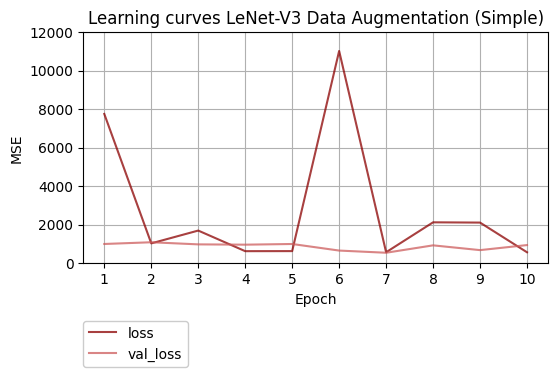

In [ ]:
plot_loss(model=history_lenet_v3, 
          ylim=[0,12000],
          model_name=f"{history_lenet_v3.model.__class__.__doc__}")

### 3.3.3. Observations

The training phase shows clearly underfitting of model V3. This may be causesd that too much augmentation was applied to prevent overfitting, resulting in a model that lacks the necessary complexity to accurately represent the data. Compared to model V2, model V3 shows no improvement in validation loss and training loss.

To address this issue, we could modify the augmentation parameters or remove some of the augmentation layers. However, given that augmentation is computationally expensive and time-consuming, we will first explore other techniques to address overfitting. If the other techniques fail to produce the desired results, we will revisit the augmentation approach.

## 3.4. LeNet-V4 Dropout layers

We will modify our V2 architecture by incorporating dropout layers. These dropout layers will be added after the dense layers because they are the one with the greater number of parameters and thus they're likely to excessively co-adapting themselves causing overfitting. Furthermore this is currently the most widely adopted practice. This method was also recommended by Hinton's original paper from 2012. [7][8][9]  
We will then train three separate models, each with a different dropout rate of 0.5, 0.25, and 0.1, respectively. Finally, their performance is compared.

In [ ]:
class LeNet_v4(tf.keras.Model):
    '''LeNet-V4 Dropout layers'''
    def __init__(self, seed=0,
                conv_1_filters = 6, 
                conv_2_filters = 16,
                kernel = (5,5),
                dropout_rate = 0.5
                 ):
        super().__init__()
        # Convolutional layers (with learnable parameters)
        self.resize = layers.Rescaling(1./255)
        self.conv_1 = layers.Conv2D(filters=conv_1_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="same")
        self.conv_2 = layers.Conv2D(filters=conv_2_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="same") 
        self.dense_1 = layers.Dense(units=120, activation="relu", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense_2 = layers.Dense(units=84, activation="relu", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.flatten = layers.Flatten()
        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.resize(inputs)
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        x = self.output_layer(x)

        return x


### 3.4.1. Building the model

In [ ]:
# Define the dropout rates and a dropout dict
# to save the three models.
dropout_rates = [0.5, 0.25, 0.1]
dropout_dict = {}

for dropout_rate in dropout_rates:
    model = LeNet_v4(dropout_rate=dropout_rate)
    model.build(input_shape)
    dropout_dict[f"{model.__doc__}_{dropout_rate}"] = model

# Test if the models were created correctly
dropout_dict["LeNet-V4 Dropout layers_0.5"].summary()

Model: "le_net_v4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  456       
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 dense (Dense)               multiple                  4800120   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

### 3.4.2. Compiling and training 

In [ ]:
# Compiles and trains the model.
for model in dropout_dict.keys():
    history = train_model(model=dropout_dict[model], 
                                    train_df=ds_train, 
                                    validation_df=ds_val, 
                                    epochs=epochs, 
                                    batch_size=batch_size,
                                    optimizer=optimizers.RMSprop(learning_rate=learning_rate))
    
    model_dict[f"{model}"] = history

Start training of LeNet_v4: LeNet-V4 Dropout layers
Epoch 1/10
88/88 [==============================] - 13s 139ms/step - loss: 618.6378 - MAPE: 367.2099 - val_loss: 441.4301 - val_MAPE: 243.5914
Epoch 2/10
88/88 [==============================] - 12s 139ms/step - loss: 407.4972 - MAPE: 231.1930 - val_loss: 560.0675 - val_MAPE: 585.0382
Epoch 3/10
88/88 [==============================] - 12s 135ms/step - loss: 338.4978 - MAPE: 168.4993 - val_loss: 222.8577 - val_MAPE: 121.4394
Epoch 4/10
88/88 [==============================] - 12s 133ms/step - loss: 303.6008 - MAPE: 140.0612 - val_loss: 196.3776 - val_MAPE: 186.1907
Epoch 5/10
88/88 [==============================] - 12s 138ms/step - loss: 267.6765 - MAPE: 130.7085 - val_loss: 178.2209 - val_MAPE: 89.4062
Epoch 6/10
88/88 [==============================] - 12s 134ms/step - loss: 269.7514 - MAPE: 119.4786 - val_loss: 298.4068 - val_MAPE: 69.0729
Epoch 7/10
88/88 [==============================] - 12s 133ms/step - loss: 232.9351 - MAPE: 

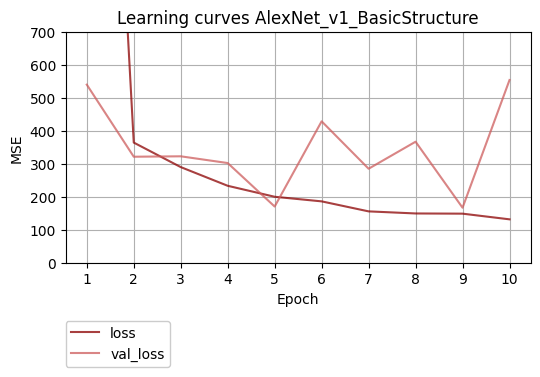

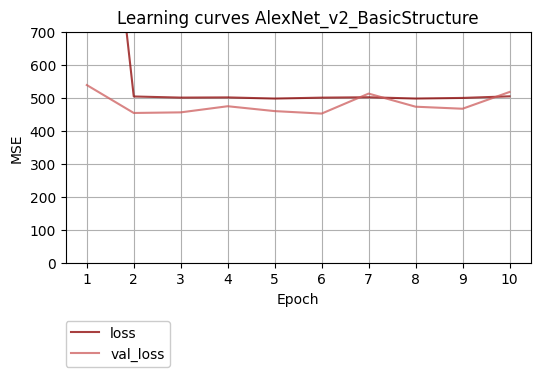

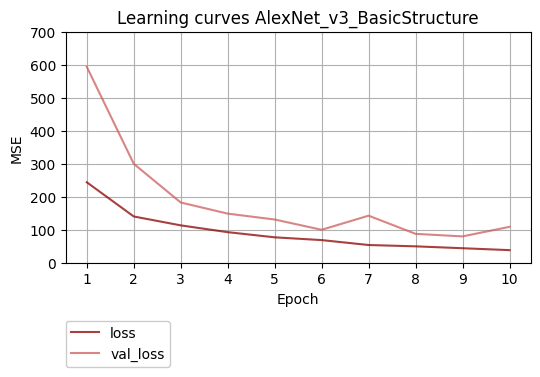

In [ ]:
model_names = list(model_dict.keys())
for plot in [model_names[-3], model_names[-2], model_names[-1]]:
    plot_loss(model_dict[plot], [0, 700], plot)

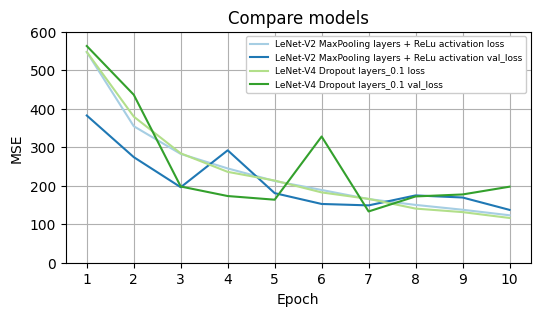

In [ ]:
# Compare model V2 with model V4 (dropout_rate = 0.1)
plot_compare_models(model_names=[model_names[1], model_names[-1]],
                    model_dict=model_dict,
                    ylim=[0,600])

### 3.4.3. Observations

Although model V4 with a dropout rate of 0.1 outperforms model V2 without overfitting measurements, the validation_loss is still showing strong fluctuations across epochs. As a result, we will explore the potential benefits of regularization techniques.

## 3.5 LeNet-V5 L2 Regularization
We have the option to select either Lasso (L1) or Ridge (L2) regression as regularization techniques.  
Our preference is to utilize L2 regularization because it pushes the weight parameters towards zero, but not exactly to zero. As a result, we can retain all of the extracted features in our model and avoid losing any important information. Furthermore, L2 regularization imposes a lower penalty on smaller weight values relative to larger ones, thereby reducing the model's dependence on a small set of features.[10][11]

We will regularize the kernels of our convolutional and dense layers.

In [ ]:
class LeNet_v5(tf.keras.Model):
    '''LeNet-V5 L2 Regularization '''
    def __init__(self, seed=0,
                conv_1_filters = 6, 
                conv_2_filters = 16,
                kernel = (5,5),
                regularizer = None
                 ):
        super().__init__()
        # Convolutional layers (with learnable parameters)
        self.resize = layers.Rescaling(1./255)
        self.conv_1 = layers.Conv2D(filters=conv_1_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="same",
                                    kernel_regularizer=regularizer)
        self.conv_2 = layers.Conv2D(filters=conv_2_filters, kernel_size=kernel, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed), padding="same",
                                    kernel_regularizer=regularizer) 
        self.dense_1 = layers.Dense(units=120, activation="relu", kernel_regularizer=regularizer,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense_2 = layers.Dense(units=84, activation="relu", kernel_regularizer=regularizer,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.flatten = layers.Flatten()
        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.resize(inputs)
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.output_layer(x)

        return x

### 3.5.1. Building the model

In [ ]:
regularizer = regularizers.l2(0.001)

lenet_v5 = LeNet_v5(regularizer=regularizer)
lenet_v5.build(input_shape)
lenet_v5.summary()

Model: "le_net_v5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  456       
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 dense (Dense)               multiple                  4800120   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

### 3.5.2. Compiling and training

In [ ]:
history_lenet_v5 = train_model(model=lenet_v5, 
                                train_df=ds_train, 
                                validation_df=ds_val, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                optimizer=optimizers.RMSprop(learning_rate=learning_rate))

model_dict[f"{history_lenet_v5.model.__class__.__doc__}"] = history_lenet_v5

Start training of LeNet_v5: LeNet-V5 L2 Regularization 
Epoch 1/10
88/88 [==============================] - 13s 134ms/step - loss: 550.0272 - MAPE: 403.2785 - val_loss: 399.5328 - val_MAPE: 432.4225
Epoch 2/10
88/88 [==============================] - 12s 131ms/step - loss: 353.1407 - MAPE: 230.3953 - val_loss: 382.3706 - val_MAPE: 365.6230
Epoch 3/10
88/88 [==============================] - 12s 130ms/step - loss: 288.4427 - MAPE: 164.7501 - val_loss: 277.9683 - val_MAPE: 217.3651
Epoch 4/10
88/88 [==============================] - 12s 132ms/step - loss: 236.9575 - MAPE: 123.7446 - val_loss: 173.8435 - val_MAPE: 106.8891
Epoch 5/10
88/88 [==============================] - 12s 131ms/step - loss: 201.2578 - MAPE: 98.6290 - val_loss: 172.0425 - val_MAPE: 75.3556
Epoch 6/10
88/88 [==============================] - 12s 131ms/step - loss: 178.5813 - MAPE: 90.8379 - val_loss: 151.5686 - val_MAPE: 64.0112
Epoch 7/10
88/88 [==============================] - 12s 130ms/step - loss: 159.0312 - MAPE

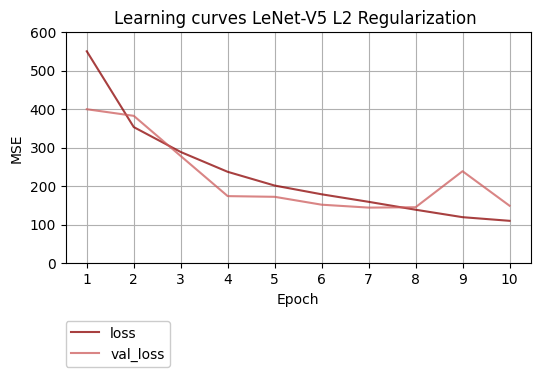

In [ ]:
plot_loss(history_lenet_v5, 
          model_name= f"{history_lenet_v5.model.__class__.__doc__}",
          ylim=[0, 600])

### 3.5.3. Observations
Although we observe instances of both underfitting and overfitting during certain epochs, it's worth noting that model V5 has outperformed all other models we have tested. 
As a summary for the implementation of various techniques to prevent overfitting, we can say that the L2 regularization on the dense and convolutional layers achieves the best results.


## 3.6. LeNet-V6 Adam optimizer

Our next step involves improving the performance of our best model by changing the optimizer. We will replace the default `RMSprop()` optimizer used in the `compile()` method with the widely used `Adam()` optimizer. The `Adam()` optimizer is known for its effectiveness in various problem types and is considered one of the best optimizers available. Unlike `RMSprop()`, `Adam()` incorporates momentum, which facilitates faster and more reliable convergence on complex optimization problems. [12]

As architecture we will use LeNet_v5, the model with L2 regularization.

### 3.6.1. Building the model

In [ ]:
regularizer = regularizers.l2(0.001)

lenet_v6 = LeNet_v5(regularizer=regularizer)
lenet_v6.build(input_shape)
lenet_v6.summary()

Model: "le_net_v5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  456       
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 dense (Dense)               multiple                  4800120   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

### 3.6.2. Compiling and training

In [ ]:
history_lenet_v6 = train_model(model=lenet_v6, 
                                train_df=ds_train, 
                                validation_df=ds_val, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                optimizer=optimizers.Adam(learning_rate=learning_rate))

model_dict[f"{history_lenet_v6.model.__class__.__doc__}_Adam"] = history_lenet_v6

Start training of LeNet_v5: LeNet-V5 L2 Regularization 
Epoch 1/10
88/88 [==============================] - 13s 139ms/step - loss: 505.4455 - MAPE: 417.1917 - val_loss: 388.8426 - val_MAPE: 416.0228
Epoch 2/10
88/88 [==============================] - 12s 136ms/step - loss: 271.3856 - MAPE: 195.1895 - val_loss: 189.6256 - val_MAPE: 119.8424
Epoch 3/10
88/88 [==============================] - 12s 131ms/step - loss: 200.1520 - MAPE: 121.9688 - val_loss: 165.1440 - val_MAPE: 94.6319
Epoch 4/10
88/88 [==============================] - 12s 131ms/step - loss: 161.4306 - MAPE: 96.1045 - val_loss: 154.2723 - val_MAPE: 79.5297
Epoch 5/10
88/88 [==============================] - 12s 132ms/step - loss: 135.1905 - MAPE: 81.2574 - val_loss: 141.1545 - val_MAPE: 99.2434
Epoch 6/10
88/88 [==============================] - 12s 131ms/step - loss: 122.4346 - MAPE: 74.8163 - val_loss: 130.4932 - val_MAPE: 80.2826
Epoch 7/10
88/88 [==============================] - 12s 132ms/step - loss: 101.9350 - MAPE: 6

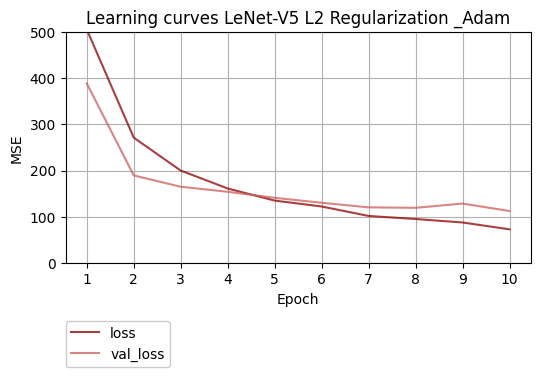

In [ ]:
plot_loss(history_lenet_v6, 
          model_name= f"{history_lenet_v6.model.__class__.__doc__}_Adam",
          ylim=[0, 500])

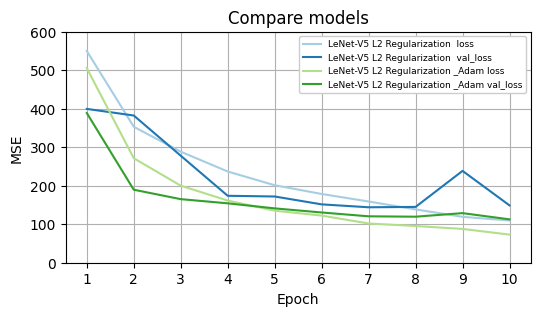

In [ ]:
model_names = list(model_dict.keys())
plot_compare_models(model_names=[model_names[-2], model_names[-1]],
                    model_dict=model_dict,
                    ylim=[0,600])

### 3.6.3. Observations

We can see, that the training and validation loss of LeNet-V6 decreased compared to LeNet-V5, because of the adam optimizer, which shows it was a good step to use the Adam.

## 3.7. LeNet-V7 Enhance kernels of Conv2D

Having successfully reduced overfitting and taken the first step towards improving performance, we have decided to modify the filter/kernel specifications of our convolutional layers. Specifically, we plan to double the size of units in each convolutional layer and decrease the kernel size to (3,3). This decision comes from the fact that the original LeNet architecture was designed to recognize simple images with minimal variations in appearance, whereas faces have far more details. Therefore, we will increase the number of units and reduce the kernel size to be able to extract better features and identify more details.

In this attempt we will use LeNet-V6 and change the architecture of the convolutional layers as mentioned before.

### 3.7.1. Building the model

In [ ]:
regularizer = regularizers.l2(0.001)

lenet_v7 = LeNet_v5(regularizer=regularizer, kernel=(3,3), conv_1_filters=12, conv_2_filters=32)
lenet_v7.build(input_shape)
lenet_v7.summary()

Model: "le_net_v5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  336       
                                                                 
 conv2d_1 (Conv2D)           multiple                  3488      
                                                                 
 dense (Dense)               multiple                  9600120   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

### 3.7.2. Compiling and training 

In [ ]:
history_lenet_v7 = train_model(model=lenet_v7, 
                                train_df=ds_train, 
                                validation_df=ds_val, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                optimizer=optimizers.Adam(learning_rate=learning_rate))

model_dict[f"{history_lenet_v7.model.__class__.__doc__}_Adam_enhanced"] = history_lenet_v7

Start training of LeNet_v5: LeNet-V5 L2 Regularization 
Epoch 1/10
88/88 [==============================] - 13s 141ms/step - loss: 447.9009 - MAPE: 363.8596 - val_loss: 270.6042 - val_MAPE: 299.5703
Epoch 2/10
88/88 [==============================] - 12s 138ms/step - loss: 236.9792 - MAPE: 159.9314 - val_loss: 178.8683 - val_MAPE: 110.1398
Epoch 3/10
88/88 [==============================] - 12s 137ms/step - loss: 178.4291 - MAPE: 114.1214 - val_loss: 156.6015 - val_MAPE: 118.7547
Epoch 4/10
88/88 [==============================] - 12s 135ms/step - loss: 145.3421 - MAPE: 98.7206 - val_loss: 138.8895 - val_MAPE: 99.5369
Epoch 5/10
88/88 [==============================] - 12s 134ms/step - loss: 133.6730 - MAPE: 89.3376 - val_loss: 120.9626 - val_MAPE: 81.2554
Epoch 6/10
88/88 [==============================] - 12s 134ms/step - loss: 117.5762 - MAPE: 79.7893 - val_loss: 144.0314 - val_MAPE: 67.6071
Epoch 7/10
88/88 [==============================] - 12s 135ms/step - loss: 100.6772 - MAPE: 

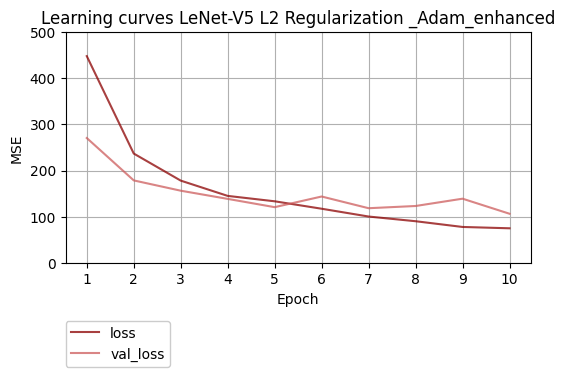

In [ ]:
plot_loss(history_lenet_v7, 
          model_name= f"{history_lenet_v6.model.__class__.__doc__}_Adam_enhanced",
          ylim=[0, 500])

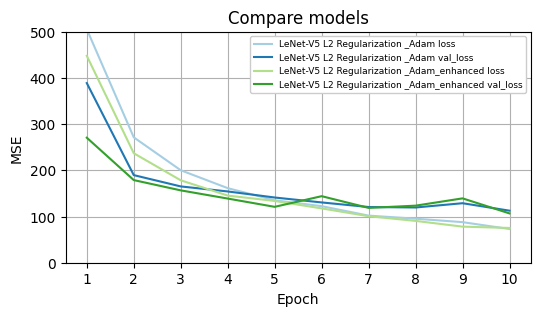

In [ ]:
model_names = list(model_dict.keys())
plot_compare_models(model_names=[model_names[-2], model_names[-1]],
                    model_dict=model_dict,
                    ylim=[0,500])

### 3.7.3. Observations

Despite increasing the complexity of LeNet-V6 to improve feature extraction, we observed only a marginal decrease in the training and validation loss.

## 3.8 Conclusion

After examining the development of our LeNet models, we have concluded the following:

- The original LeNet architecture did not meet fully our requirements, but adding MaxPooling layers and the ReLu activation function resulted in better convergence over epochs and a decrease in loss functions.
- Only applying L2 regularization on the convolutional and dense layers produced the desired reduction in overfitting, data augmentation and the addition of dropout layers between the fully connected layers failed.
- The introduction of the widely-used Adam optimizer led to improvements in the performance of our LeNet model.
- Increasing the number of filters and the kernel size in the convolutional layers to enhance feature extraction showed better convergence compared to all other models, although the performance improvement was only marginally better than the LeNet model with the Adam optimizer.


To summarize, our modifications to the LeNet architecture produced a not satisfactory performance and we will discontinue our research on this particular architecture. We have determined that the LeNet lacks the necessary complexity to effectively detect the small details and patterns of human faces required for accurate age prediction. As a result, we will shift our focus to the AlexNet in our future steps, which we will discuss in more depth in the next notebook.

# 4. Second Architecture - the AlexNet

Alexnet won the Imagenet large-scale visual recognition chellenge in 2012. The model was proposed in 2012 in the research paper named "Imagenet Classification with Deep Convolution Neural Network" [13] by Alex Krizhevsky and his colleagues. In this model, the depth of the network was increased in comparison to Lenet-5. The Alexnet has eight layers with learnable parameters. The model consists of 5 convolutional layers with a combination of max pooling followed by 3 fully connected dense layers and they use Relu activation in each of these layers except the output layer.

They found out that using the relu as an activation function accelerated the speed of the training process by almost six times. They also used the dropout layers, that prevented their model from overfitting. Further, the model is trained on the Imagenet dataset. The Imagenet dataset has almost 14 million images across a thousand classes. [14]


### 4.1. AlexNet-V1 Basic Architecture

When compared to our last LeNet-V7 architecture we expect the AlexNet Architecture to be more robust for a problem of facial age detection for the following reasons:

*   **Depth and Complexity:** A larger number of convolutional layers and number of filter within each one of these layers will allow the model to learn more complex features and patterns, which is very useful for age detection, as each face has a lot of different features.

*   **Larger receptive fields:** They may not be as effective in capturing fine details as smaller receptive fields. But its deeper layers can learn more complex features and patterns, even if the initial layer has a larger receptive field.

*   **Number of dense layers and respective neurons:** AlexNet is able to learn more complex and high-level features from the input-images, which can lead to improved performance in age detections tasks.

Despite having some insights from our experience with Lenet on what may work better for this specific problem age detection problem, we've opted to begin with the basic architecture of AlexNet. Our plan is to build on this foundation by incorporating our past and future learnings as we move forward.

The only difference from the original AlexNet Architecture is that in the last dense layer instead of 1000 units and softmax activation function, we are only using 1 unit and a linear activation function, since we no longer have a multi-classification problem, but a regression. We also use a batch normalization layer after each convolutional layer. Batch normalization was introduced as a technique to improve the performance of deep neural networks in 2015 [15], which is two years after the publication of the original AlexNet paper.

**Note:** Overall this increase in complexity can lead to overfitting so it is important to acess the performance of the basic structure and then do adjustments in case overfitting is present.






#### 4.1.1. Building the Model

In [ ]:
class AlexNet_v1(tf.keras.Model):
    '''AlexNet-V1 Basic Architecture'''
    def __init__(self, seed=0):
        super().__init__()
        
        # Rescaling.
        self.rescaling = layers.Rescaling(1./255)
        # Convolutional layers (with learnable parameters).
        self.conv1 = layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv2 = layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))   
        self.conv3 = layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv4 = layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv5 = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))

        # Batch normalization layers (with learnable parameters, gamma and beta).
        self.bn1 = layers.BatchNormalization() 
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()
        self.bn5 = layers.BatchNormalization()
        
        # Classifier's head.
        self.dense1 = layers.Dense(units=4096,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense2 = layers.Dense(units=4096,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))
        self.dropout = layers.Dropout(0.5)
        self.flatten = layers.Flatten()

        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.rescaling(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x


In [ ]:
# Creating an instance of the AlexNet_v1 class.
alexnetv1 = AlexNet_v1()

# Building the DAG, which represents the connections between the layers
# in the neural network, showing the flow of data from one layer to another
# during the forward pass (inference).
alexnetv1.build(input_shape)

# Checking the network.
alexnetv1.summary()

Model: "alex_net_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  34944     
                                                                 
 conv2d_1 (Conv2D)           multiple                  614656    
                                                                 
 conv2d_2 (Conv2D)           multiple                  885120    
                                                                 
 conv2d_3 (Conv2D)           multiple                  1327488   
                                                                 
 conv2d_4 (Conv2D)           multiple                  884992    
                                                                 
 batch_normalization (BatchN  multiple                 

#### 4.1.2. Compiling and Training

In [ ]:
history_alexnet_v1=train_model(model=alexnetv1,
                               train_df=ds_train,
                               validation_df=ds_val,
                               epochs=epochs,
                               batch_size=64,
                               optimizer=optimizers.Adam(learning_rate=learning_rate))

model_dict[f"{history_alexnet_v1.model.__class__.__name__}_BasicStructure"] = history_alexnet_v1

Start training of AlexNet_v1: AlexNet-V1 Basic Architecture
Epoch 1/10
88/88 [==============================] - 17s 159ms/step - loss: 2976.7754 - MAPE: 478.0960 - val_loss: 540.6506 - val_MAPE: 443.7592
Epoch 2/10
88/88 [==============================] - 12s 132ms/step - loss: 365.0420 - MAPE: 306.8440 - val_loss: 322.2003 - val_MAPE: 272.6962
Epoch 3/10
88/88 [==============================] - 12s 134ms/step - loss: 290.7961 - MAPE: 198.9849 - val_loss: 323.4704 - val_MAPE: 198.8174
Epoch 4/10
88/88 [==============================] - 12s 134ms/step - loss: 234.1148 - MAPE: 144.0853 - val_loss: 303.0441 - val_MAPE: 340.5052
Epoch 5/10
88/88 [==============================] - 12s 130ms/step - loss: 200.8535 - MAPE: 118.5493 - val_loss: 171.2233 - val_MAPE: 101.2315
Epoch 6/10
88/88 [==============================] - 12s 135ms/step - loss: 186.9155 - MAPE: 106.1054 - val_loss: 429.4837 - val_MAPE: 436.8539
Epoch 7/10
88/88 [==============================] - 12s 131ms/step - loss: 156.59

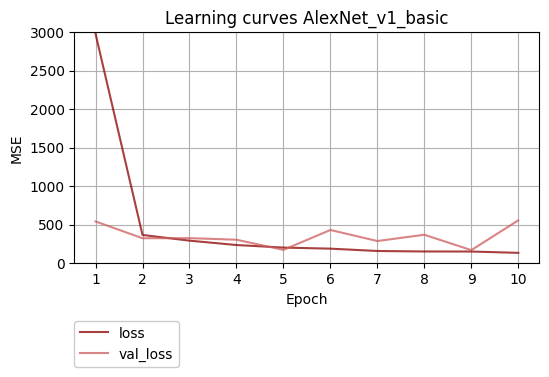

In [ ]:
plot_loss(history_alexnet_v1, 
          model_name= "AlexNet_v1_basic",
          ylim=[0, 3000])

#### 4.1.3. Observations

At first sight, by using the basic AlexNet architecture we see that we have high overfitting and the performance wasn't better than the previous architectures we created for LeNet. As explained previously, there are several ways to deal with overfitting. Here we are going to revisit the augmentation approach, although before it didn't show effective, but now with a more complex model it may produce better results as the capacity of learning is bigger.

### 4.2. AlexNet-V2 Basic Architecture + Data Augmentation (Simple)

#### 4.2.1. Building the Model

We will use the data augmentation techniques of `RandomFlip()`, `RandomRotation()`, `RandomBrigthness()` and `RandomContrast()`, as selected in the example of 3.3. LeNet-V3 Data Augmentation (Simple). However, in contrast to what was done with LeNet we will decrease the augmentation parameters due to the underfitting experienced. We decrease `RandomRotation()` from 0.2 to 0.1, `RandomBrigthness()` from 0.2 to 0.1, and `RandomContrast()` from 0.25 to 0.1.

In [ ]:
class AlexNet_v2(tf.keras.Model):
    '''AlexNet-V2 Basic Architecture + Data Augmentation (Simple)'''
    def __init__(self, seed=0):
        super().__init__()

        # Augmentation.
        self.aug1 = layers.RandomFlip()
        self.aug2 = layers.RandomRotation(factor=0.1)
        self.aug3 = layers.RandomBrightness(factor=0.1)
        self.aug4 = layers.RandomContrast(factor=0.1)

        # Rescaling.
        self.rescaling = layers.Rescaling(1./255)

        # Convolutional layers (with learnable parameters).
        self.conv1 = layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv2 = layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))   
        self.conv3 = layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv4 = layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv5 = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))

        # Batch normalization layers (with learnable parameters, gamma and beta).
        self.bn1 = layers.BatchNormalization() 
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()
        self.bn5 = layers.BatchNormalization()
        
        # Classifier's head.
        self.dense1 = layers.Dense(units=4096,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense2 = layers.Dense(units=4096,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))
        self.dropout = layers.Dropout(0.5)
        self.flatten = layers.Flatten()

        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.rescaling(inputs)
        x = self.aug1(x)
        x = self.aug2(x)
        x = self.aug3(x)
        x = self.aug4(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x


In [ ]:
alexnetv2 = AlexNet_v2()
alexnetv2.build(input_shape)
alexnetv2.summary()

Model: "alex_net_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    multiple                  0         
                                                                 
 random_rotation (RandomRota  multiple                 0         
 tion)                                                           
                                                                 
 random_brightness (RandomBr  multiple                 0         
 ightness)                                                       
                                                                 
 random_contrast (RandomCont  multiple                 0         
 rast)                                                           
                                                                 
 rescaling (Rescaling)       multiple                  0         
                                                       

#### 4.2.2. Compiling and Training

In [ ]:
history_alexnet_v2=train_model(model=alexnetv2,
                               train_df=ds_train,
                               validation_df=ds_val,
                               epochs=epochs,
                               batch_size=64,
                               optimizer=optimizers.Adam(learning_rate=learning_rate))

model_dict[f"{history_alexnet_v2.model.__class__.__name__}_BasicStructure"] = history_alexnet_v2

Start training of AlexNet_v2: AlexNet-V2 Basic Architecture + Data Augmentation (Simple)
Epoch 1/10
88/88 [==============================] - 127s 1s/step - loss: 1783.4104 - MAPE: 513.9908 - val_loss: 539.3981 - val_MAPE: 302.9672
Epoch 2/10
88/88 [==============================] - 120s 1s/step - loss: 504.7860 - MAPE: 435.6276 - val_loss: 454.7806 - val_MAPE: 428.9271
Epoch 3/10
88/88 [==============================] - 122s 1s/step - loss: 501.3524 - MAPE: 448.9778 - val_loss: 456.6219 - val_MAPE: 427.2966
Epoch 4/10
88/88 [==============================] - 122s 1s/step - loss: 501.9260 - MAPE: 442.9125 - val_loss: 475.1787 - val_MAPE: 367.5574
Epoch 5/10
88/88 [==============================] - 123s 1s/step - loss: 498.4914 - MAPE: 438.7101 - val_loss: 460.4320 - val_MAPE: 412.3944
Epoch 6/10
88/88 [==============================] - 122s 1s/step - loss: 501.2309 - MAPE: 441.8932 - val_loss: 452.9431 - val_MAPE: 433.6577
Epoch 7/10
88/88 [==============================] - 123s 1s/step

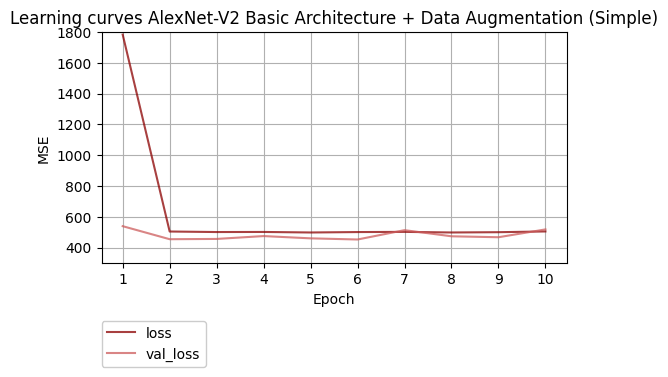

In [ ]:
plot_loss(history_alexnet_v2, 
          model_name= "AlexNet-V2 Basic Architecture + Data Augmentation (Simple)",
          ylim=[300, 1800])

#### 4.2.3. Observations

When compared to 4.1. AlexNet-V1 Basic Architecture we were able to decrease the overfitting, showing once again some degree of underfitting in the ealy epochs, but we failed on getting a significant better validation loss. Once again, the reason for this is that data augmentation applied on a facial age problem leads to samples that are no longer representative of real-world data, unrealistic images. Moving ahead we are going to adress overfitting and performance with some new techniques and others that were explored previously and returned better results.

### 4.3. AlexNet-V3 Less Complex Architecture

This approach will imply modifying the architecture of AlexNet to make it less susceptible to overfitting and to improve its performance. It should be noted that the original AlexNet was designed to tackle a multi-classification problem with 1000 classes. While our problem is also intricate, it is not as intricate as the original problem for which this architecture was developed. This may pose a problem as complex and deeper models applied to simpler cases can overfit by learning the training set too well. Therefore, we plan to reduce the model's complexity and assess if it yields better results for this particular problem.

To decrease overfitting we decided to decrease the number of kernels of each convolutional layer to half and decrease the number of neurons in each dense layer to half. To improve performance, previously we learned on "3.7. LeNet-V7 Enhance kernels of Conv2D" that a decrease of the kernel size is generally preferred given the fact that it captures better local features. Taking that into consideration, we decrease the kernel size from the first and second convolutional layer from (11, 11) and (5, 5) to (3, 3) and (3, 3).  Finally, we are also decreasing the stride of (4, 4) in the first layer to (2, 2) as smaller strides are better at preserving spatial details.



#### 4.3.1. Building the Model

In [ ]:
class AlexNet_v3(tf.keras.Model):
    '''AlexNet-V3 Less Complex Architecture 2'''
    def __init__(self, seed=0):
        super().__init__()
        
        # Rescaling.
        self.rescaling = layers.Rescaling(1./255)

        # Convolutional layers (with learnable parameters).
        self.conv1 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2,2), 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv2 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))   
        self.conv3 = layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(2,2), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv4 = layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(2,2), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv5 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed))

        # Batch normalization layers (with learnable parameters, gamma and beta).
        self.bn0 = layers.BatchNormalization()
        self.bn1 = layers.BatchNormalization() 
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()
        self.bn5 = layers.BatchNormalization()
        
        # Classifier's head.
        self.dense1 = layers.Dense(units=2048,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense2 = layers.Dense(units=2048,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))
        self.dropout = layers.Dropout(0.5)
        self.flatten = layers.Flatten()

        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.rescaling(inputs)
        x = self.bn0(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x


In [ ]:
alexnetv3 = AlexNet_v3()
alexnetv3.build(input_shape)
alexnetv3.summary()

Model: "alex_net_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_2 (Conv2D)           multiple                  221376    
                                                                 
 conv2d_3 (Conv2D)           multiple                  331968    
                                                                 
 conv2d_4 (Conv2D)           multiple                  221312    
                                                                 
 batch_normalization (BatchN  multiple                 

#### 4.3.2. Compiling and Training

In [ ]:
history_alexnet_v3=train_model(model=alexnetv3,
                               train_df=ds_train,
                               validation_df=ds_val,
                               epochs=epochs,
                               batch_size=64,
                               optimizer=optimizers.Adam(learning_rate=learning_rate))

model_dict[f"{history_alexnet_v3.model.__class__.__name__}_BasicStructure"] = history_alexnet_v3

Start training of AlexNet_v3: AlexNet-V3 Less Complex Architecture 2
Epoch 1/10
88/88 [==============================] - 14s 139ms/step - loss: 244.7969 - MAPE: 141.3769 - val_loss: 594.6107 - val_MAPE: 139.4176
Epoch 2/10
88/88 [==============================] - 12s 134ms/step - loss: 141.1695 - MAPE: 78.5996 - val_loss: 300.7206 - val_MAPE: 128.9488
Epoch 3/10
88/88 [==============================] - 12s 131ms/step - loss: 114.1723 - MAPE: 67.6864 - val_loss: 183.5321 - val_MAPE: 63.3768
Epoch 4/10
88/88 [==============================] - 12s 136ms/step - loss: 93.5977 - MAPE: 57.8956 - val_loss: 149.7526 - val_MAPE: 52.5591
Epoch 5/10
88/88 [==============================] - 12s 134ms/step - loss: 77.9581 - MAPE: 53.0914 - val_loss: 131.9447 - val_MAPE: 54.6004
Epoch 6/10
88/88 [==============================] - 12s 138ms/step - loss: 69.5652 - MAPE: 46.9849 - val_loss: 100.8241 - val_MAPE: 40.6334
Epoch 7/10
88/88 [==============================] - 13s 141ms/step - loss: 54.6555 - 

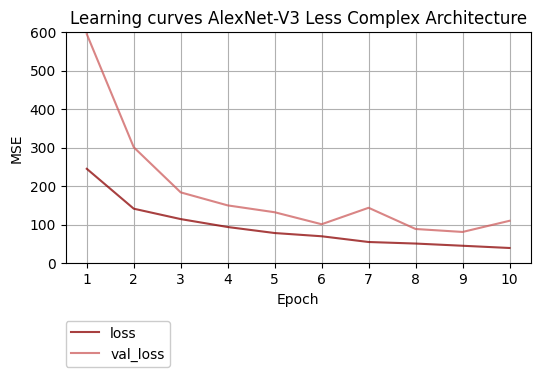

In [ ]:
plot_loss(history_alexnet_v3, 
          model_name= "AlexNet-V3 Less Complex Architecture",
          ylim=[0, 600])

#### 4.3.3. Observations

Compared to the basic AlexNet architecture, this simpler architecture shows a decrease in overfitting and an improvement in performance, indicated by a substantially lower validation loss. To address the remaining degree of overfitting, in the next architecture, we will modify the dropout rate and introduce L2 regularization.

### 4.4. AlexNet-V4 Less Complex Architecture + Dropout Rate (0.25) + L2 Regulatization (0.001)

We are going to pick the architecture from 4.3. and we are going to decrease the dropout rate. Throughout the whole exploration of the AlexNet architecture we kept the dropout at 0.50. A low dropout may lead to overfitting, but a high dropout will make the network not have enough units left to learn a good representation of the data. 

We experimented dropout rates of 0.25 and 0.10 and the best performance was attained with a dropout rate of 0.25. On top of that, we are going to add a L2 regularization term with a lambda of 0.001 within the layers (modifying the layer's weight update rule by adding a small multiple of the weight vector to the gradient of the loss function with respect to the weights). These two techniques help prevent overfitting and are the last techniques we are going to try to implement and see if they have an effect.

#### 4.4.1. Building the Model

In [ ]:
class AlexNet_v4(tf.keras.Model):
    '''AlexNet-V4 Less Complex Architecture + Dropout Rate (0.25) + L2 Regularization (0.001)'''
    def __init__(self, regularizer = None, seed=0):
        super().__init__()
        
        # Rescaling.
        self.rescaling = layers.Rescaling(1./255)

        # Convolutional layers (with learnable parameters).
        self.conv1 = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed),
                                    kernel_regularizer=regularizer)
        self.conv2 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed),
                                 kernel_regularizer=regularizer)   
        self.conv3 = layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(2,2), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed),
                                 kernel_regularizer=regularizer)
        self.conv4 = layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(2,2), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed),
                                 kernel_regularizer=regularizer)
        self.conv5 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed),
                                 kernel_regularizer=regularizer)

        # Batch normalization layers (with learnable parameters, gamma and beta).
        self.bn0 = layers.BatchNormalization()
        self.bn1 = layers.BatchNormalization() 
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        self.bn4 = layers.BatchNormalization()
        self.bn5 = layers.BatchNormalization()
        
        # Classifier's head.
        self.dense1 = layers.Dense(units=2048,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizer)
        self.dense2 = layers.Dense(units=2048,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizer)
        self.output_layer = layers.Dense(units=1, activation="linear", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizer)
        
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))
        self.dropout = layers.Dropout(0.25)
        self.flatten = layers.Flatten()

        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.rescaling(inputs)
        x = self.bn0(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x


In [ ]:
regularizer = regularizers.l2(0.001)

alexnetv4 = AlexNet_v4(regularizer=regularizer)
alexnetv4.build(input_shape)
alexnetv4.summary()

Model: "alex_net_v4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_2 (Conv2D)           multiple                  221376    
                                                                 
 conv2d_3 (Conv2D)           multiple                  331968    
                                                                 
 conv2d_4 (Conv2D)           multiple                  221312    
                                                                 
 batch_normalization (BatchN  multiple                 

#### 4.4.2. Compilling and Training

In [ ]:
history_alexnet_v4=train_model(model=alexnetv4,
                               train_df=ds_train,
                               validation_df=ds_val,
                               epochs=epochs,
                               batch_size=64,
                               optimizer=optimizers.Adam(learning_rate=learning_rate),
                               )

model_dict[f"{history_alexnet_v4.model.__class__.__name__}_BasicStructure"] = history_alexnet_v4

Start training of AlexNet_v4: AlexNet-V4 Less Complex Architecture + Dropout Rate (0.25) + L2 Regularization (0.001)
Epoch 1/10
88/88 [==============================] - 19s 142ms/step - loss: 231.5685 - MAPE: 131.1077 - val_loss: 558.0654 - val_MAPE: 179.9554
Epoch 2/10
88/88 [==============================] - 12s 134ms/step - loss: 130.3473 - MAPE: 71.7439 - val_loss: 487.0648 - val_MAPE: 95.0711
Epoch 3/10
88/88 [==============================] - 12s 138ms/step - loss: 111.4125 - MAPE: 66.6133 - val_loss: 263.7404 - val_MAPE: 66.4512
Epoch 4/10
88/88 [==============================] - 12s 139ms/step - loss: 84.7613 - MAPE: 53.8776 - val_loss: 111.0035 - val_MAPE: 69.3034
Epoch 5/10
88/88 [==============================] - 12s 134ms/step - loss: 75.0624 - MAPE: 49.0558 - val_loss: 117.6493 - val_MAPE: 51.1351
Epoch 6/10
88/88 [==============================] - 12s 131ms/step - loss: 58.1666 - MAPE: 42.4324 - val_loss: 113.9119 - val_MAPE: 53.4461
Epoch 7/10
88/88 [====================

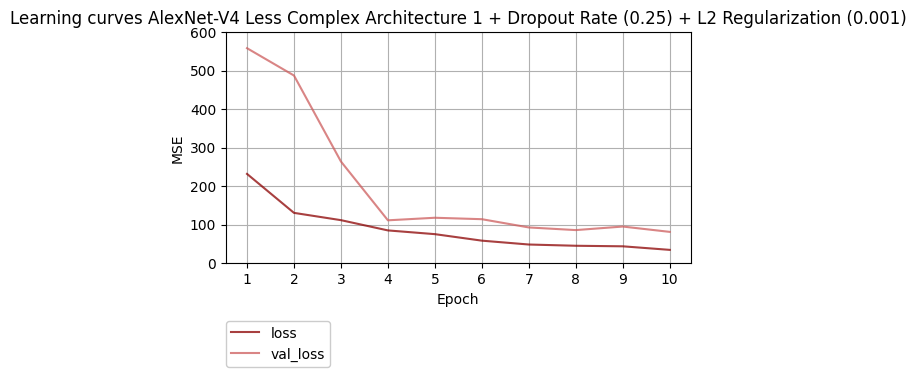

In [ ]:
plot_loss(history_alexnet_v4, 
          model_name= "AlexNet-V4 Less Complex Architecture 1 + Dropout Rate (0.25) + L2 Regularization (0.001)",
          ylim=[0, 600])

#### 4.4.3. Observations

Although there was a slightly decrease in the validation error, we kept the same level of overfitting. One can associate this to the model already being well-regularized through other means (e.g. by using batch normalization or early stopping), then changing the dropout rate and adding the regularizer may not provide much additional benefit.


## 4.5 Conclusion

After examining the development of our AlexNet models, we have concluded the following:

*   Although the initial AlexNet architecture was not a perfect fit for our facial age detection task, we were able to improve the performance of the model by making a few modifications. Specifically, we reduced the number of filters, decreased the filter size, and adjusted the stride of the convolutional layers. Additionally, we decreased the number of neurons in the dense layers. These changes led to better convergence over epochs and a reduction in the loss function.

*   The use of Data Augmentation did not enhance the performance of the model and, in fact, indicated signs of underfitting in early epochs.

*   We observed a slight improvement in performance by incorporating L2 regularization and reducing the dropout rate on our simplified model.

In summary, our adaptations to the AlexNet architecture resulted in a superior model compared to the previous versions created with LeNet. We have decided to define our final handcrafted model as "AlexNet-V4 Less Complex Architecture + Dropout Rate (0.25) + L2 Regularization (0.001)". Moving ahead, we are going to train LeNet-V7 and AlexNet-V4 with the whole training set (train+val) and we are going to test the performance on the test set.





# 5. Training LeNet-V7 and AlexNet-V4 on the whole Training Set

## 5.1. Create datasets

In [ ]:
# Data generators and parameters.
train_generator = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

generate_params = {
    'target_size' : (200,200),
    'color_mode' : 'rgb',
    'class_mode' : 'raw',
    'batch_size' : batch_size,
    'seed' : seed
}

In [ ]:
# Generators instances and data spliting.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_images_df,
    x_col='file_name',
    y_col='age_label',
    shuffle=True,
    **generate_params
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_images_df,
    x_col='file_name',
    y_col='age_label',
    shuffle=True,
    **generate_params
)

Found 7008 validated image filenames.
Found 1752 validated image filenames.


In [ ]:
# Create folders to save the models.
!mkdir -p /content/drive/MyDrive/FacialAgeProject/models
!mkdir -p /content/drive/MyDrive/FacialAgeProject/models/best_models

# Define the save path of the models.
path_save_model =  "/content/drive/MyDrive/FacialAgeProject/models/best_models"

## 5.2. Train LeNet-V7

In [ ]:
regularizer = regularizers.l2(0.001)

lenet_v7_final = LeNet_v5(regularizer=regularizer, kernel=(3,3), conv_1_filters=12, conv_2_filters=32)
lenet_v7_final.build(input_shape)
lenet_v7_final.summary()

Model: "le_net_v5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  336       
                                                                 
 conv2d_1 (Conv2D)           multiple                  3488      
                                                                 
 dense (Dense)               multiple                  9600120   
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                                 
 dense_2 (Dense)             multiple                  85        
                                                                 
 activation (Activation)     multiple                  0 

In [ ]:
history_lenet_v7_final = train_model(model=lenet_v7_final, 
                                train_df=train_images, 
                                validation_df=test_images, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                optimizer=optimizers.Adam(learning_rate=learning_rate))

Start training of LeNet_v5: LeNet-V5 L2 Regularization 
Epoch 1/10
110/110 [==============================] - 28s 250ms/step - loss: 434.5482 - MAPE: 351.6863 - val_loss: 245.2228 - val_MAPE: 178.2684
Epoch 2/10
110/110 [==============================] - 14s 128ms/step - loss: 219.3479 - MAPE: 154.1629 - val_loss: 216.9639 - val_MAPE: 98.6015
Epoch 3/10
110/110 [==============================] - 14s 127ms/step - loss: 157.8066 - MAPE: 108.8309 - val_loss: 163.2813 - val_MAPE: 112.5857
Epoch 4/10
110/110 [==============================] - 14s 128ms/step - loss: 139.1120 - MAPE: 96.8174 - val_loss: 141.9657 - val_MAPE: 92.8250
Epoch 5/10
110/110 [==============================] - 14s 126ms/step - loss: 118.9403 - MAPE: 84.5853 - val_loss: 133.2756 - val_MAPE: 89.7635
Epoch 6/10
110/110 [==============================] - 14s 131ms/step - loss: 105.0190 - MAPE: 75.4573 - val_loss: 128.7026 - val_MAPE: 74.7908
Epoch 7/10
110/110 [==============================] - 14s 128ms/step - loss: 89.7

In [ ]:
# Saves the best model as .keras file.
history_lenet_v7_final.model.save(filepath=path_save_model + "/handcrafted_LeNet-V7", 
                                  overwrite=True, 
                                  save_format="keras")

print(f"LeNet saved successfully into {path_save_model}")

INFO:tensorflow:Assets written to: C:/Users/jkick/OneDrive - NOVAIMS/Sem. 2/Deep Learning/Project/FacialAgeProject/models/best_models/handcrafted_LeNet-V7\assets


INFO:tensorflow:Assets written to: C:/Users/jkick/OneDrive - NOVAIMS/Sem. 2/Deep Learning/Project/FacialAgeProject/models/best_models/handcrafted_LeNet-V7\assets


LeNet saved successfully into C:/Users/jkick/OneDrive - NOVAIMS/Sem. 2/Deep Learning/Project/FacialAgeProject/models/best_models


In [ ]:
# Save the history dictionary of our best model.
name_file = 'LeNet-V7-history.pkl'
save_object = history_lenet_v7_final.history
save_path = os.path.join(path_save_model, "handcrafted_LeNet-V7", name_file)
with open(save_path, 'wb') as fp:
    pickle.dump(save_object, fp)
    print(f'{name_file} saved successfully into {path_save_model}')

LeNet-V7-history.pkl saved successfully into C:/Users/jkick/OneDrive - NOVAIMS/Sem. 2/Deep Learning/Project/FacialAgeProject/models/best_models


## 5.3. Train AlexNet-V4

In [ ]:
regularizer = regularizers.l2(0.001)

alexnetv4_final = AlexNet_v4(regularizer=regularizer)
alexnetv4_final.build(input_shape)
alexnetv4_final.summary()

Model: "alex_net_v4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_2 (Conv2D)           multiple                  221376    
                                                                 
 conv2d_3 (Conv2D)           multiple                  331968    
                                                                 
 conv2d_4 (Conv2D)           multiple                  221312    
                                                                 
 batch_normalization (BatchN  multiple                 

In [ ]:
history_alexnetv4_final = train_model(model=alexnetv4_final, 
                                train_df=train_images, 
                                validation_df=test_images, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                optimizer=optimizers.Adam(learning_rate=learning_rate))

Start training of AlexNet_v4: AlexNet-V4 Less Complex Architecture + Dropout Rate (0.25) + L2 Regularization (0.001)
Epoch 1/10
110/110 [==============================] - 16s 136ms/step - loss: 221.9533 - MAPE: 124.5135 - val_loss: 580.1154 - val_MAPE: 124.5928
Epoch 2/10
110/110 [==============================] - 14s 129ms/step - loss: 122.5641 - MAPE: 69.6688 - val_loss: 171.3176 - val_MAPE: 130.3992
Epoch 3/10
110/110 [==============================] - 14s 128ms/step - loss: 97.0895 - MAPE: 58.5574 - val_loss: 125.6493 - val_MAPE: 100.5370
Epoch 4/10
110/110 [==============================] - 14s 129ms/step - loss: 85.1809 - MAPE: 52.9839 - val_loss: 115.8079 - val_MAPE: 69.8257
Epoch 5/10
110/110 [==============================] - 14s 130ms/step - loss: 69.8212 - MAPE: 44.8065 - val_loss: 126.9360 - val_MAPE: 49.1181
Epoch 6/10
110/110 [==============================] - 14s 129ms/step - loss: 54.0606 - MAPE: 40.3819 - val_loss: 101.0207 - val_MAPE: 51.5363
Epoch 7/10
110/110 [=====

In [ ]:
# Saves the best model as .keras file.
history_alexnetv4_final.model.save(filepath=path_save_model + "/handcrafted_AlexNet-V4", 
                                  overwrite=True, 
                                  save_format="keras")

print(f"AlexNet saved successfully into {path_save_model}")

INFO:tensorflow:Assets written to: C:/Users/jkick/OneDrive - NOVAIMS/Sem. 2/Deep Learning/Project/FacialAgeProject/models/best_models/handcrafted_AlexNet-V4\assets


INFO:tensorflow:Assets written to: C:/Users/jkick/OneDrive - NOVAIMS/Sem. 2/Deep Learning/Project/FacialAgeProject/models/best_models/handcrafted_AlexNet-V4\assets


AlexNet saved successfully into C:/Users/jkick/OneDrive - NOVAIMS/Sem. 2/Deep Learning/Project/FacialAgeProject/models/best_models


In [ ]:
# Save the history dictionary of our best model.
name_file = 'AlexNet-V4-history.pkl'
save_object = history_alexnetv4_final.history
save_path = os.path.join(path_save_model, "handcrafted_AlexNet-V4", name_file)
with open(save_path, 'wb') as fp:
    pickle.dump(save_object, fp)
    print(f'{name_file} saved successfully into {path_save_model}')

AlexNet-V4-history.pkl saved successfully into C:/Users/jkick/OneDrive - NOVAIMS/Sem. 2/Deep Learning/Project/FacialAgeProject/models/best_models
